# A tiny simulation and integration testing
Test if all functionalities work well together. This is a self-contained test. No outside dataset required.

## Data generation

In [1]:
from functools import reduce
import pickle as pkl

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.metrics

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1" 

In [2]:
np.random.seed(42)

## Create a grid
width = 50
height = 8
xs = np.arange(0, width)
ys = np.arange(0, height)
grid_x, grid_y = np.meshgrid(xs, ys)
grid_x = grid_x.ravel()
grid_y = grid_y.ravel()
df = pd.DataFrame(np.array([grid_x, grid_y]).T, 
                  columns=['x', 'y'], 
                  index=reduce(np.char.add, ['cell_', grid_x.astype(str), '_', grid_y.astype(str)]))

## Randomly assign cell types
for y in range(3, 8):
    random_columns = np.random.choice([0, 1, 2], width, p=[0.3, 0.3, 0.4])
    
    df.loc[(random_columns[df['x']] == 0) & (df['y'] == y), 'celltype'] = 'B'
    df.loc[(random_columns[df['x']] == 1) & (df['y'] == y), 'celltype'] = 'C'
    df.loc[(random_columns[df['x']] == 2) & (df['y'] == y), 'celltype'] = 'D'

df.loc[(df['y'] <= 2), 'celltype'] = 'A'

## Generate receptor expression
def go(d, x, y, width, height):
    if d == 'left':
        x = x - 1
    elif d == 'right':
        x = x + 1
    elif d == 'up':
        y = y + 1
    elif d == 'down':
        y = y - 1
    elif d == 'left-up':
        x = x - 1
        y = y + 1
    elif d == 'right-up':
        x = x + 1
        y = y + 1
    elif d == 'left-down':
        x = x - 1
        y = y - 1 
    elif d == 'right-down':
        x = x + 1
        y = y - 1
    
    if x < 0 or y < 0 or x >= width or y >= height:
        return None, None
    else:
        return x, y

df['R+'] = 0
for i in df.index:
    if df.loc[i, 'celltype'] in ['B', 'C']:
        for d in ['left', 'right', 'up', 'down', 'left-up', 'right-up', 'left-down', 'right-down']:
            x, y = go(d, df.loc[i, 'x'], df.loc[i, 'y'], width, height)
            if x is not None and y is not None:
                j = f'cell_{x}_{y}'
                if df.loc[j, 'celltype'] == 'A':
                    if np.random.rand() < 1.:
                        df.loc[i, 'R+'] = 1

meta_expr_split = df.shape[1] # Number of columns for metadata, the rest is "expression"

# Housekeeping genes that are uniform over all cell types
df['H1'] = 50
df['H2'] = 50
df['H3'] = 50
df['H4'] = 50

# Cell identity genes that are over expressed in the corresponding cell type
df['A1'] = 1
df['A2'] = 1
df['B1'] = 1
df['B2'] = 1
df['C1'] = 1
df['C2'] = 1
df['D1'] = 1
df['D2'] = 1

df.loc[df['celltype'] == 'A', 'A1'] = 50 
df.loc[df['celltype'] == 'A', 'A2'] = 50
df.loc[df['celltype'] == 'B', 'B1'] = 50
df.loc[df['celltype'] == 'B', 'B2'] = 50
df.loc[df['celltype'] == 'C', 'C1'] = 50
df.loc[df['celltype'] == 'C', 'C2'] = 50
df.loc[df['celltype'] == 'D', 'D1'] = 50
df.loc[df['celltype'] == 'D', 'D2'] = 50

# LR
df['R'] = 1
df.loc[:, 'R'] = 100 * df['R+']

features = df.columns[meta_expr_split:].tolist()
print(*features)

expr = np.random.poisson(df[features])
expr = pd.DataFrame(expr, index=df.index, columns=features)
expr[['H1', 'H2', 'H3', 'H4']] = 50

H1 H2 H3 H4 A1 A2 B1 B2 C1 C2 D1 D2 R


In [3]:
meta = df.iloc[:, :meta_expr_split]

## Run Steamboat
### Prepare the dataset

In [4]:
import os
import sys
import pickle as pkl
import matplotlib.pyplot as plt

## Add path to the directory containing steamboat.
sys.path.append("../../") 

import torch
import pandas as pd
import numpy as np
import scipy as sp
import scanpy as sc
import squidpy as sq
import steamboat as sf # Steamboat Factorization -> sf
import steamboat.tools

/home/shaohenl/miniconda3/envs/py311_torch251_cuda121/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/shaohenl/miniconda3/envs/py311_torch251_cuda121/lib/python3.11/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/home/shaohenl/miniconda3/envs/py311_torch251_cuda121/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


In [5]:
import steamboat.integrated_model

In [6]:
device = "cuda"

In [7]:
adata = sc.AnnData(expr, obs=meta)
adata.obsm['spatial'] = np.array(meta[['x', 'y']])
adata.obs['global'] = 0
adata

adatas = [adata] # You can include multiple datasets here.
adatas = sf.prep_adatas(adatas, log_norm=True)
dataset = sf.make_dataset(adatas, regional_obs=['global'])

  0%|          | 0/1 [00:00<?, ?it/s]

Using ['global'] as regional annotations.


  0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
dataset[0]

(tensor([[3.9544, 3.9544, 3.9544,  ..., 0.0000, 0.0000, 0.0000],
         [3.8760, 3.8760, 3.8760,  ..., 1.0610, 1.0610, 0.0000],
         [3.9350, 3.9350, 3.9350,  ..., 0.6948, 0.6948, 0.0000],
         ...,
         [3.9286, 3.9286, 3.9286,  ..., 4.0743, 3.8035, 0.0000],
         [3.8522, 3.8522, 3.8522,  ..., 3.9806, 4.1247, 0.0000],
         [3.9911, 3.9911, 3.9911,  ..., 3.9911, 3.6423, 0.0000]]),
 tensor([[102, 101, 100,  ..., 299, 298, 297],
         [  0,   0,   0,  ..., 399, 399, 399]], dtype=torch.int32),
 [tensor([[3.9120, 3.9120, 3.9120, 3.9120, 1.8063, 1.8541, 1.2269, 1.2732, 1.1065,
           1.0958, 1.4518, 1.4204, 0.3696]])],
 [tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
             0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
             0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
             0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
             0,   0,   0,

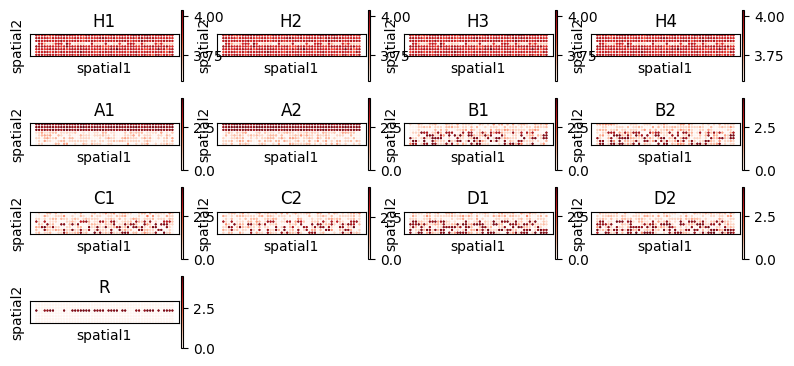

In [9]:
sq.pl.spatial_scatter(adatas[0], color=adatas[0].var_names, shape=None, figsize=(2, 1), size=1., 
                      legend_fontsize=9, cmap='Reds', ncols=4)

/home/shaohenl/miniconda3/envs/py311_torch251_cuda121/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


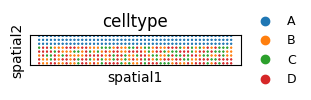

In [10]:
sq.pl.spatial_scatter(adatas[0], color='celltype', shape=None, figsize=(3, 2), size=1., 
                      legend_fontsize=9, cmap='Reds', ncols=4)

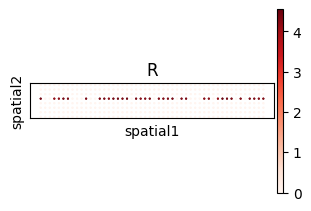

In [11]:
sq.pl.spatial_scatter(adatas[0], color='R', shape=None, figsize=(3, 2), size=1., 
                      legend_fontsize=9, cmap='Reds', ncols=4)

### Train and inspect the metagenes

In [12]:
from torch import nn

In [13]:
sf.set_random_seed(0)
model = sf.integrated_model.Steamboat(adata.var_names.tolist(), n_heads=5, n_scales=3)
model = model.to(device)

model.fit(dataset, entry_masking_rate=0.3, feature_masking_rate=0.3, 
          flat_k_penalty=0., flat_k_penalty_args={'kind': 'cosine'},
          switch_l2_penalty=0.0,
          weight_l2_penalty=1e-4,
          max_epoch=10000, 
          loss_fun=nn.HuberLoss(),
          opt=torch.optim.Adam, opt_args=dict(lr=0.1), stop_eps=1e-5, report_per=200, stop_tol=1000, device=device)

# model.fit(dataset, entry_masking_rate=0.0, feature_masking_rate=0.0, 
#          flat_k_penalty=0., flat_k_penalty_args={'kind': 'cosine'},
#          switch_l2_penalty=0.0,
#          weight_l2_penalty=1e-4,
#          max_epoch=10000, 
#          loss_fun=nn.HuberLoss(),
#          opt=torch.optim.Adam, opt_args=dict(lr=0.001), stop_eps=1e-5, report_per=200, stop_tol=1000)
# 0. k for everything & implicit switch
# 0.5 max pooling vs attention pooling
# 1. Start with "switch: 1x ego + 0x ..."
# 2. More careful normalization of q and k.
# 3. q, v conjugation

# sf.tools.plot_transforms(model, figsize=(4, 4), vmin=0.0, vmax=.5, top=0)

[2024-12-04 12:17:41,360::train::INFO] Epoch 1: train_loss 1.23570, reg 0.000043
[2024-12-04 12:17:42,111::train::INFO] Epoch 201: train_loss 0.26669, reg 0.004752
[2024-12-04 12:17:42,859::train::INFO] Epoch 401: train_loss 0.15106, reg 0.005423
[2024-12-04 12:17:43,607::train::INFO] Epoch 601: train_loss 0.22334, reg 0.005756
[2024-12-04 12:17:44,354::train::INFO] Epoch 801: train_loss 0.27393, reg 0.006135
[2024-12-04 12:17:45,101::train::INFO] Epoch 1001: train_loss 0.26906, reg 0.006029
[2024-12-04 12:17:45,854::train::INFO] Epoch 1201: train_loss 0.17629, reg 0.006072
[2024-12-04 12:17:46,600::train::INFO] Epoch 1401: train_loss 0.15817, reg 0.006061
[2024-12-04 12:17:47,344::train::INFO] Epoch 1601: train_loss 0.27599, reg 0.006143
[2024-12-04 12:17:47,746::train::INFO] Epoch 1709: train_loss 0.18307, reg 0.006075
[2024-12-04 12:17:47,747::train::INFO] Stopping criterion met.


Steamboat(
  (spatial_gather): BilinearAttention(
    (bias): NonNegBias(
      (elu): ELU(alpha=1.0)
    )
    (q): NonNegLinear(
      (elu): ELU(alpha=1.0)
    )
    (k): NonNegLinear(
      (elu): ELU(alpha=1.0)
    )
    (v): NonNegLinear(
      (elu): ELU(alpha=1.0)
    )
    (cosine_similarity): CosineSimilarity()
  )
)

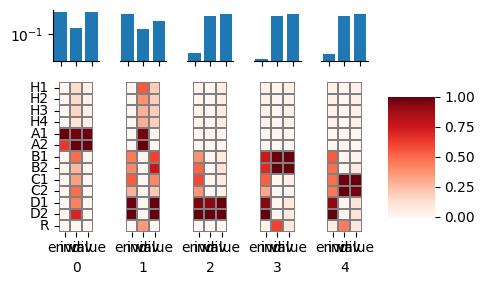

In [14]:
def plot_regional_transforms(model, top: int = 3, reorder: bool = False, 
                    figsize: str | tuple[float, float] = 'auto', 
                    vmin: float = 0., vmax: float = 1.,
                    xticklabels: tuple[str, str, str] = ("envir", "indiv", 'value')):
    """Plot all metagenes

    :param model: Steamboat model
    :param top: Number of top genes per metagene to plot, defaults to 3
    :param reorder: Reorder the genes by metagene, or keep the orginal ordering, defaults to False
    :param figsize: Size of the figure, defaults to 'auto'
    :param vmin: minimum value in the color bar, defaults to 0.
    :param vmax: maximum value in the color bar, defaults to 1.
    """
    n_heads = model.spatial_gather.n_heads
    n_scales = model.spatial_gather.n_scales

    q = model.spatial_gather.q.weight.detach().cpu()
    k = model.spatial_gather.k.weight.detach().cpu()
    v = model.spatial_gather.v.weight.detach().cpu().T
    # switch = model.spatial_gather.switch().detach().cpu()

    if top > 0:
        if reorder:
            rank_v = np.argsort(-v, axis=1)[:, :top]
            rank_q = np.argsort(-q, axis=1)[:, :top]
            rank_k = np.argsort(-k, axis=1)[:, :top]
            feature_mask = {}
            for i in range(n_heads):
                for j in rank_k[i, :]:
                    feature_mask[j] = None
                for j in rank_q[i, :]:
                    feature_mask[j] = None
                for j in rank_v[i, :]:
                    feature_mask[j] = None
            feature_mask = list(feature_mask.keys())
        else:
            rank_v = np.rank(v)
            rank_q = np.rank(q)
            rank_k = np.rank(k)
            max_rank = np.max(np.vstack([rank_v, rank_q, rank_k]), axis=0)
            feature_mask = (max_rank > (max_rank.max() - 3))
            
        chosen_features = np.array(model.features)[feature_mask]
    else:
        feature_mask = list(range(len(model.features)))
        chosen_features = np.array(model.features)

    if figsize == 'auto':
        figsize = (n_heads * 0.49 + 2 + .5, len(chosen_features) * 0.15 + .25 + .75)
    # print(figsize)
    fig, axes = plt.subplots(2, n_heads + 1, sharey='row', sharex='col',
                                          figsize=figsize, 
                                          height_ratios=(.75, len(chosen_features) * .15 + .25))
    plot_axes = axes[1]
    bar_axes = axes[0]
    cbar_ax = plot_axes[-1].inset_axes([0.0, 0.1, 1.0, .8])
    common_params = {'linewidths': .05, 'linecolor': 'gray', 'yticklabels': chosen_features, 
                     'cmap': 'Reds', 'cbar_kws': {"orientation": "vertical"}, 'square': True,
                     'vmax': vmax, 'vmin': vmin}

    for i in range(0, n_heads):
        title = ''
        what = f'{i}'
        
        to_plot = np.vstack((k[i, feature_mask],
                             q[i, feature_mask],
                             v[i, feature_mask])).T
        
        true_vmax = to_plot.max(axis=0)
        # print(true_vmax)
        to_plot /= true_vmax
 
        bar_axes[i].bar(np.arange(len(true_vmax)) + .5, true_vmax)
        bar_axes[i].set_xticks(np.arange(len(true_vmax)) + .5, [''] * len(true_vmax))
        bar_axes[i].set_yscale('log')
        bar_axes[i].set_title(title, size=10, fontweight='bold')
        if i != 0:
            bar_axes[i].get_yaxis().set_visible(False)
        for pos in ['right', 'top', 'left']:
            if pos == 'left' and i == 0:
                continue
            else:
                bar_axes[i].spines[pos].set_visible(False)
        sns.heatmap(to_plot, xticklabels=xticklabels, ax=plot_axes[i], 
                    **common_params, cbar_ax=cbar_ax)
        plot_axes[i].set_xlabel(f"{what}")
        
    # All text straight up
    for i in range(n_heads):
        plot_axes[i].set_xticklabels(plot_axes[i].get_xticklabels(), rotation=0)

    for i in range(1, n_heads):
        plot_axes[i].get_yaxis().set_visible(False)

    # Remove duplicate cbars
    bar_axes[-1].set_visible(False)

    plot_axes[-1].get_yaxis().set_visible(False)
    plot_axes[-1].get_xaxis().set_visible(False)
    for pos in ['right', 'top', 'bottom', 'left']:
        plot_axes[-1].spines[pos].set_visible(False)
    # axes[-1].set_visible(False)

    fig.align_xlabels()
    plt.tight_layout()

plot_regional_transforms(model, top=0)

In [15]:
model.spatial_gather.bias.bias

tensor([[3.7033e+00, 3.7062e+00, 3.7084e+00, 3.7057e+00, 1.5289e-03, 2.6286e-03,
         1.9098e-01, 1.3143e-01, 1.4441e-01, 2.6884e-01, 4.9312e-02, 3.4496e-02,
         1.2386e-02]], device='cuda:0', grad_fn=<AddBackward0>)

In [16]:
plt.bar(range(model.spatial_gather.n_heads), model.spatial_gather.switch().T.detach().cpu().numpy()[1, :])

AttributeError: 'BilinearAttention' object has no attribute 'switch'

In [ ]:
model.spatial_gather.switch()

### Annotate the adata(s) with the scores

In [ ]:
sf.tools.annotate_adatas([adata], dataset, model, get_recon=False)

### Clustering

In [ ]:
sf.tools.neighbors(adata)

In [ ]:
sf.tools.leiden(adata, resolution=0.1)

In [ ]:
sq.pl.spatial_scatter(adata, color='steamboat_clusters', shape=None, figsize=(3, 2), size=1., 
                      legend_fontsize=9, cmap='Reds', ncols=4)

In [ ]:
labels=['A', 'B', 'C', 'D', '0', '1', '2', '3', '4', '5']

df = pd.DataFrame(sklearn.metrics.confusion_matrix(adata.obs['celltype'], adata.obs['steamboat_clusters'], labels=labels),
            columns=labels, index=labels).loc[['A', 'B', 'C', 'D'], ['0', '1', '2', '3', '4', '5']]
df /= df.sum(axis=0)
fig, ax = plt.subplots(figsize=(2, 1.2))
sns.heatmap(df, linewidths=.5, ax=ax)
ax.set_xlabel('Clustering')
ax.set_ylabel('Cell type')

### Segmentation

In [ ]:
sf.tools.segment(adata, resolution=0.5)

In [ ]:
sq.pl.spatial_scatter(adata, color='steamboat_spatial_domain', shape=None, figsize=(3, 2), size=1., 
                      legend_fontsize=9, cmap='Reds', ncols=4)

In [ ]:
labels=['A', 'B', 'C', 'D', '0', '1']

df = pd.DataFrame(sklearn.metrics.confusion_matrix(adata.obs['celltype'], adata.obs['steamboat_spatial_domain'], labels=labels),
            columns=labels, index=labels).loc[['A', 'B', 'C', 'D'], ['0', '1']]
df = df.div(df.sum(axis=1), axis=0)
fig, ax = plt.subplots(figsize=(.8, 1.2))
sns.heatmap(df, linewidths=.5, ax=ax)
ax.set_xlabel('Spatial domain')
ax.set_ylabel('Cell type')

In [ ]:
df